# Tutorial: creating and comparing graph and timeseries embeddings
The following notebook provides a demonstration how to create and compare embeddings from a timeseries and graphs created from this timeseries with different methods.

In [51]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from core.model import Timeseries, TimeseriesPreprocessing, TimeseriesPreprocessingSegmentation, TimeseriesPreprocessingSlidingWindow, TimeseriesPreprocessingComposite, TimeseriesView, TimeGraph, ToSequenceVisitorSlidingWindow, ToSequenceVisitor, ToSequenceVisitorOrdinalPartition
from tsg_io.input import CsvFile, TsFile
from from_graph.strategy_to_time_sequence import StrategyNextValueInNodeRandom, StrategyNextValueInNodeRandomForSlidingWindow, StrategyNextValueInNodeRoundRobin, StrategyNextValueInNodeRoundRobinForSlidingWindow, StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs, StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph, StrategySelectNextNodeRandomly, StrategySelectNextNodeRandomDegree, StrategySelectNextNodeRandomWithRestart, StrategyNextValueInNodeOrdinalPartition
from to_graph.strategy_linking_graph import StrategyLinkingGraphByValueWithinRange, LinkNodesWithinGraph
from to_graph.strategy_linking_multi_graphs import LinkGraphs
from to_graph.strategy_to_graph import BuildTimeseriesToGraphNaturalVisibilityStrategy, BuildTimeseriesToGraphHorizontalVisibilityStrategy, BuildTimeseriesToGraphOrdinalPartition, BuildTimeseriesToGraphQuantile
from embeddings.ts2g2_embeddings import EmbeddingRanking, VisitorGraphEmbeddingModelDoc2Vec, VisitorTimeseriesEmbeddingModelTS2Vec
import pandas as pd

# Accessing data
We first get path to the data.

In [52]:
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")
path = CsvFile(apple_path, "Close").from_csv()

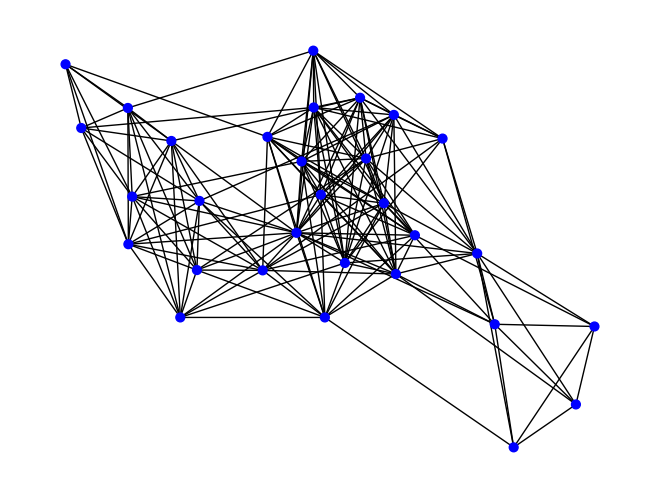

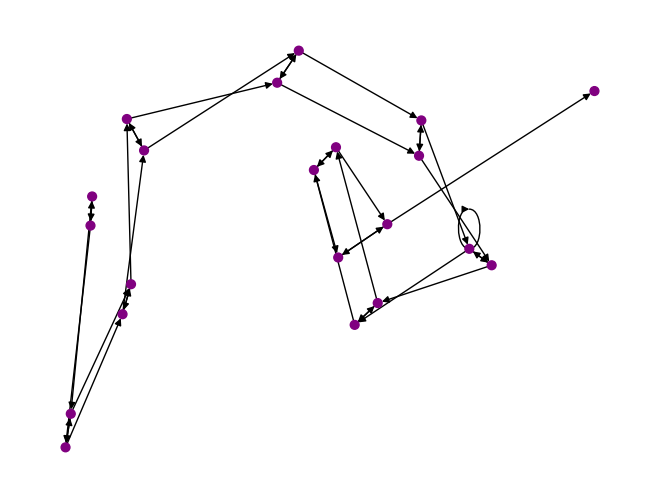

In [53]:
timegraph_natural_visibility = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 90))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().with_limit(1).get_strategy())\
    .add_edge(0,2)\
    .add_edge(13, 21, weight = 17)\
    .link(LinkNodesWithinGraph().by_value(StrategyLinkingGraphByValueWithinRange(2)).seasonalities(15))\
    .draw("blue")

timegraph_ordinal_partition = Timeseries(CsvFile(apple_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(60, 120))\
    .add(Timeseries(CsvFile(apple_path, "Close").from_csv())\
        .with_preprocessing(TimeseriesPreprocessingSegmentation(120, 180)))\
    .to_histogram(15)\
    .to_graph(BuildTimeseriesToGraphOrdinalPartition(10, 5).get_strategy())\
    .link(LinkGraphs().time_cooccurrence())\
    .draw("purple")

Then we set parameters and train models for creating embeddings.

In [54]:
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")
path = CsvFile(apple_path, "Close").from_csv()
embedding_size = 20

# to train graph embedding model, we need to provide multiple graphs. We chose arbitrary two as an example.
model_graph = VisitorGraphEmbeddingModelDoc2Vec().train_model([timegraph_natural_visibility, timegraph_ordinal_partition], embedding_size)
model_ts = VisitorTimeseriesEmbeddingModelTS2Vec().train_model(path, embedding_size, epoch=20)

# VisitorTimeseriesEmbeddingModelTS2Vec model was made with the help of TS2Vec library (available on: https://github.com/zhihanyue/ts2vec.git; version: b0088e14a99706c05451316dc6db8d3da9351163)



Epoch #0: loss=1.9688612222671509
Epoch #1: loss=1.7514606714248657
Epoch #2: loss=1.2899434566497803
Epoch #3: loss=1.4606770277023315
Epoch #4: loss=2.044621706008911
Epoch #5: loss=1.8655725717544556
Epoch #6: loss=1.9161803722381592
Epoch #7: loss=1.8975872993469238
Epoch #8: loss=1.9261128902435303
Epoch #9: loss=1.9598957300186157
Epoch #10: loss=1.1770092248916626
Epoch #11: loss=1.7016338109970093
Epoch #12: loss=1.7718662023544312
Epoch #13: loss=1.7173525094985962
Epoch #14: loss=1.8969123363494873
Epoch #15: loss=1.8530489206314087
Epoch #16: loss=1.849608063697815
Epoch #17: loss=1.712167739868164
Epoch #18: loss=1.0310852527618408
Epoch #19: loss=1.6631989479064941


# Comparing embeddings
Now that we have set the parametersand trained our models, we can create and compare embeddings. Firstly, we need to create EmbeddingRanking object and give it models and strategies for timeseries to graph conversion, we want to compare. Then we add as many of the timeseries segments as we want and rank them. Because graph embeddings are created using random walk, we repeat this process multiple times and then calculate the average score.

In [55]:
data = {'run':[], 'natural_visibility':[], 'horizontal_visibility':[], 'ordinal_partition':[], 'quantile':[]}
i = 1
while i <= 5:
    x = EmbeddingRanking(embedding_size)\
        .set_embedding_models(model_ts, model_graph)\
        .set_to_graph_strategies([BuildTimeseriesToGraphNaturalVisibilityStrategy(), BuildTimeseriesToGraphHorizontalVisibilityStrategy(), BuildTimeseriesToGraphOrdinalPartition(10, 5), BuildTimeseriesToGraphQuantile(4, 1)])\
        .add_timeseries(Timeseries(path).with_preprocessing(TimeseriesPreprocessingSegmentation(100, 200)))\
        .add_timeseries(Timeseries(path).with_preprocessing(TimeseriesPreprocessingSegmentation(300, 400)))\
        .embedding_ranking()\
        .kendall_tau_correlation()
    data['run'].append(i)
    i+=1
    data['natural_visibility'].append(x[0])
    data["horizontal_visibility"].append(x[1])
    data["ordinal_partition"].append(x[2])
    data["quantile"].append(x[3])

df = pd.DataFrame.from_dict(data)
average_values = df.mean()
print(average_values)

run                      3.0
natural_visibility       0.2
horizontal_visibility   -0.6
ordinal_partition       -0.2
quantile                -0.2
dtype: float64
